# Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
import cv2
import math
import operator
from functools import reduce

# Data loading

In [86]:
# The test images (without points)
!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
# The example images are here
!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz
# The example images are here
!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)
images = data['images']
split = int(np.round(len(images)*0.8))
pts = data['points']
# examples
examples = np.load('examples.npz', allow_pickle=True)
example_images = examples['images']

--2020-05-29 11:52:16--  http://users.sussex.ac.uk/~is321/test_images.npz
Resolving users.sussex.ac.uk (users.sussex.ac.uk)... 139.184.14.119
Connecting to users.sussex.ac.uk (users.sussex.ac.uk)|139.184.14.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74915629 (71M)
Saving to: ‘test_images.npz’

test_images.npz     100%[===================>]  71.44M  16.3MB/s    in 7.8s    

2020-05-29 11:52:24 (9.22 MB/s) - ‘test_images.npz’ saved [74915629/74915629]

--2020-05-29 11:52:26--  http://users.sussex.ac.uk/~is321/examples.npz
Resolving users.sussex.ac.uk (users.sussex.ac.uk)... 139.184.14.119
Connecting to users.sussex.ac.uk (users.sussex.ac.uk)|139.184.14.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 777627 (759K)
Saving to: ‘examples.npz’

examples.npz        100%[===================>] 759.40K   388KB/s    in 2.0s    

2020-05-29 11:52:29 (388 KB/s) - ‘examples.npz’ saved [777627/777627]

--2020-05-29 11:52:30--  http://users

In [0]:
# examples
real_test_set = np.load('test_images.npz', allow_pickle=True)
real_test_set = real_test_set['images']

In [0]:
from sklearn.model_selection import train_test_split
images, testing_images, pts, testing_pts = train_test_split(images, pts, test_size = 0.2, random_state = 0)

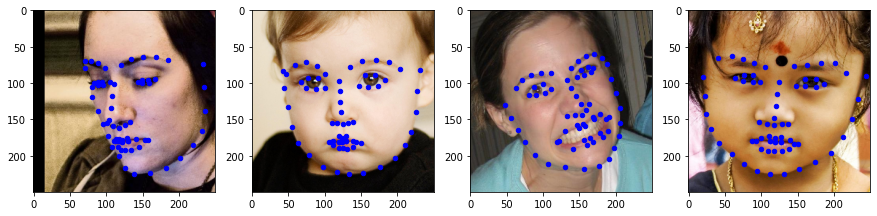

In [88]:
imgs = (0, 1, 100, 50)
plt.figure(figsize=(15,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.scatter(pts[index][:, 0], pts[index][:, 1], c='b', s=20)
  plt.imshow(images[index], cmap='gray')

# Data preprocessing

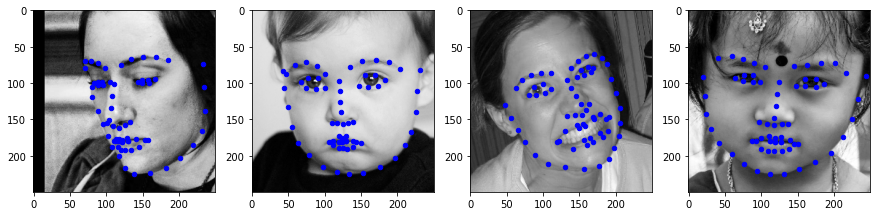

In [92]:
training_images_grayscale = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in images]
testing_images_grayscale = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in testing_images]
example_images_grayscale = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in example_images]
real_test_set = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in real_test_set]

imgs = (0, 1, 100, 50)
plt.figure(figsize=(15,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.scatter(pts[index][:, 0], pts[index][:, 1], c='b', s=20)
  plt.imshow(training_images_grayscale[index], cmap='gray')

50


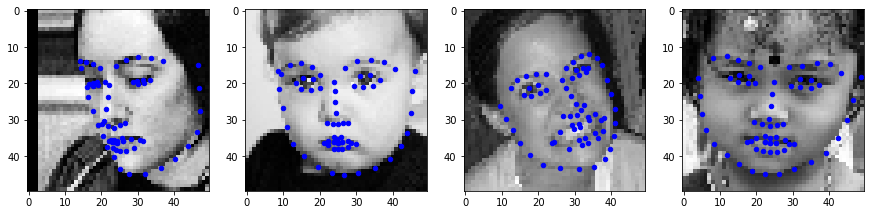

In [93]:
def resize_img(img, new_size):
  return cv2.resize(img, dsize=new_size, interpolation=cv2.INTER_CUBIC)

# Resize img to suitable resolution
scale_factor = 1/5
current_size = len(training_images_grayscale[0])
new_resolution = int(current_size * scale_factor)
print(new_resolution)
size = (new_resolution,new_resolution)

# resize_imgs
training_images_resized = [resize_img(i, size) for i in training_images_grayscale]
testing_images_resized = [resize_img(i, size) for i in testing_images_grayscale]
example_images_resized = [resize_img(i, size) for i in example_images_grayscale]
real_test_set =  [resize_img(i, size) for i in real_test_set]

# Resize pts to fit new resolution
train_pts = [(i*scale_factor) for i in pts]
test_pts = [(i*scale_factor) for i in testing_pts]

imgs = (0, 1, 100, 50)
plt.figure(figsize=(15,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.scatter(train_pts[index][:, 0], train_pts[index][:, 1], c='b', s=20)
  plt.imshow(training_images_resized[index], cmap='gray')

In [0]:
def normalize(img):
  norm_img = np.zeros((len(img),len(img)))
  return cv2.normalize(img,  norm_img, 0, 255, cv2.NORM_MINMAX)

# apply histogam equalisation
training_images_normalized = [normalize(i) for i in training_images_resized]
testing_images_normalized = [normalize(i) for i in testing_images_resized]
example_images_normalized = [normalize(i) for i in example_images_resized]
real_test_set = [normalize(i) for i in real_test_set]

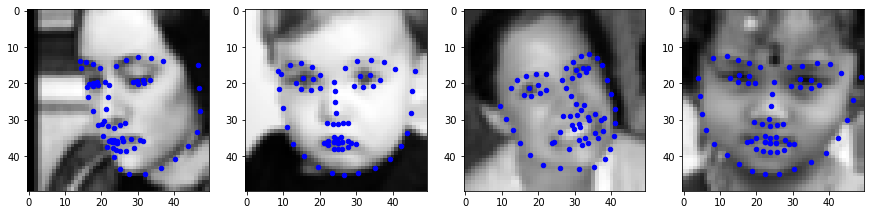

In [95]:
def apply_gaussian(img, patch_size):
  return cv2.GaussianBlur(img, (patch_size, patch_size), 0)

# apply histogam equalisation
training_images_blurred = [apply_gaussian(i, 3) for i in training_images_normalized]
testing_images_blurred = [apply_gaussian(i, 3) for i in testing_images_normalized]
example_images_blurred = [apply_gaussian(i, 3) for i in example_images_normalized]
real_test_set = [apply_gaussian(i, 3) for i in real_test_set]

imgs = (0, 1, 100, 50)
plt.figure(figsize=(15,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.scatter(train_pts[index][:, 0], train_pts[index][:, 1], c='b', s=20)
  plt.imshow(training_images_blurred[index], cmap='gray')

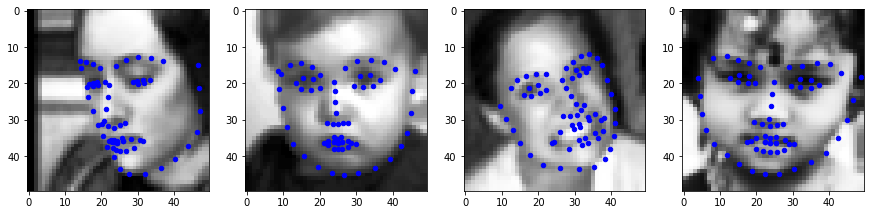

In [96]:
def image_histogram_equalization(img, number_bins=256):
  img_histogram, bins = np.histogram(img.flatten(), number_bins, density=True)
  cdf = img_histogram.cumsum()
  cdf = 255 * cdf / cdf[-1]
  img_equalized = np.interp(img.flatten(), bins[:-1], cdf)
  return img_equalized.reshape(img.shape)

# apply histogam equalisation
training_images_preprocessed = [image_histogram_equalization(i) for i in training_images_blurred]
testing_images_preprocessed= [image_histogram_equalization(i) for i in testing_images_blurred]
example_images_preprocessed = [image_histogram_equalization(i) for i in example_images_blurred]
real_test_set = [image_histogram_equalization(i) for i in real_test_set]

imgs = (0, 1, 100, 50)
plt.figure(figsize=(15,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.scatter(train_pts[index][:, 0], train_pts[index][:, 1], c='b', s=20)
  plt.imshow(training_images_preprocessed[index], cmap='gray')

# Generate initial prediction - the mean shape or 'shape 0'


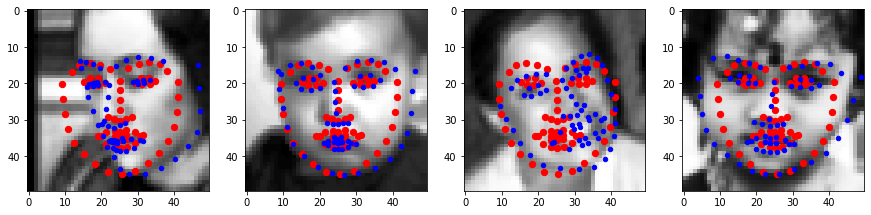

In [97]:
# generate mean start face from all points
mean_pts = np.average(train_pts[:], axis=0)

imgs = (0, 1, 100,50)
plt.figure(figsize=(15,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  # red points for mean
  plt.scatter(mean_pts[:, 0], mean_pts[:, 1], c='r', s=40)
  # blue points for ground truth
  plt.scatter(train_pts[index][:, 0], train_pts[index][:, 1], c='b', s = 20)
  plt.imshow(training_images_preprocessed[index], cmap='gray')

# Error functions

In [0]:
def sum_of_sq_errors(pred_pts, gt_pts):
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sum(np.square(pred_pts - gt_pts))

def calc_residual_errors(pred_pts, gt_pts):
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return (pred_pts - gt_pts)

In [99]:
initial_shapes = np.full(pts.shape, mean_pts)
initial_error = [sum_of_sq_errors(gt,cs) for (gt,cs) in zip(train_pts, initial_shapes)]
np.average(initial_error)

577.5911064537347

# Binary feature tests / extracting points from the face

In [0]:
# given two points on the face, create two patches. Return true if patch 1 intensity > patch 2's intensity
def binary_feaure_test(img, p1, p2, patch_size, threshold):
  patch_1 = np.sum(img [p1[0]-patch_size:p1[0]+patch_size, p1[1]-patch_size:p1[1]+patch_size])
  patch_2 = np.sum(img [p2[0]-patch_size:p2[0]+patch_size, p2[1]-patch_size:p2[1]+patch_size])
  return patch_1 - patch_2 > threshold

In [0]:
def true_features(n, n_landmarks):
  features = []
  for i in range(n):
    landmarks = np.random.choice((n_landmarks - 1), size = 2, replace=False)
    percentage_between = np.random.uniform(0, 1)
    features.append((landmarks[0], landmarks[1], percentage_between))
  return features

def cvt_to_runtime_feature(tf, shape):
  f1, f2, p = tf[0], tf[1], tf[2]
  runtime = np.zeros((1,2), dtype=int)
  # find new x
  if shape[f1][0]<shape[f2][0]:
    x = int(shape[f1][0] + (abs(shape[f1][0] - shape[f2][0]))*p)
  else:
    x = int(shape[f2][0] + (abs(shape[f1][0] - shape[f2][0]))*p)
  # find new y
  if shape[f1][1]<shape[f2][1]:
    y = int(shape[f1][1] + (abs(shape[f1][1] - shape[f2][1]))*p)
  else:
    y = int(shape[f2][1] + (abs(shape[f1][1] - shape[f2][1]))*p)
  runtime = [x,y]
  return runtime

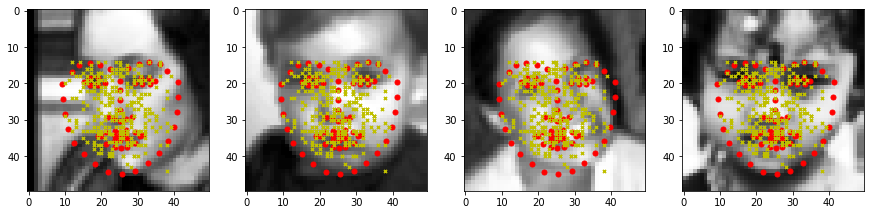

In [102]:
select_features_example = true_features(300, len(mean_pts))
runtime_features_example = np.reshape([cvt_to_runtime_feature(f, mean_pts) for f in select_features_example], (-1, 2))

# Plot images with mean shape and 400 extracted points
imgs = (0, 1, 100, 50)
plt.figure(figsize=(15,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.imshow(training_images_preprocessed[index], cmap='gray')
  plt.scatter(mean_pts[:, 0], mean_pts[:, 1], c='r', s=25)
  plt.scatter(runtime_features_example[:, 0], runtime_features_example[:, 1], c='y', s=10, marker='x')

In [0]:
def return_tree_split(features, td, depth):


  best_features={i:tuple()for i in range(depth)}
  features_found = 0
  initial_sum_residuals_sq = np.square(np.sum([calc_residual_errors(cs, gt) for key,(img,gt,cs) in td.items()]))
  alpha = 1
  root_similarity_score = initial_sum_residuals_sq/len(td)+alpha

  while features_found < depth:

    # generate random pair and threshold
    pair = (np.random.choice(range(len(features)), size=2, replace=False))
    random_threshold = np.random.uniform(-50,50)
    f1, f2 =  features[pair[0]], features[pair[1]]
    patch_size = np.random.randint(4)
    best_features[features_found]=(f1,f2, random_threshold, patch_size)
    features_found+=1

  return best_features


In [0]:
#  GREEDY CANDIDATE SPLITTING _ NOT USED FOR FINAL MODEL

# # guarantee sample isn't split too evenly to reduce overfitting
# if abs(len(split)-len(td)/2) < len(td)/6:                                                        
#   average_residual = np.average([calc_residual_errors(cs,gt) for key,(img,gt,cs) in split.items()] , axis=0) * lr
#   new_error = np.average([sum_of_sq_errors(cs-average_residual, gt) for key,(img,gt,cs) in split.items()] , axis=0)

#   if new_error < initial_error:

      # initial_shapes = [s for key,(img,gt,s) in td.items()]


# initial_error = np.average([sum_of_sq_errors(cs, gt) for key,(img,gt,cs) in td.items()])

  # true_split = {key:(img,gt,cs) for key,(img,gt,cs) in td.items() if binary_feaure_test(img, cvt_to_runtime_feature(f1, initial_shapes[key]),
#                                                           cvt_to_runtime_feature(f2, initial_shapes[key]), patch_size, random_threshold)}
# true_similarity = np.square(np.sum([calc_residual_errors(cs, gt) for key,(img,gt,cs) in true_split.items()]))
# true_similarity_score = true_similarity/len(true_split)+alpha

# false_split = {key:data for key,data in td.items() if key not in true_split.keys()}
# false_similarity = np.square(np.sum([calc_residual_errors(cs, gt) for key,(img,gt,cs) in false_split.items()]))
# false_similarity_score = false_similarity/len(false_split)+alpha


# gain = true_similarity_score + false_similarity_score - root_similarity_score

#Create training data

In [0]:
import itertools
initial_shapes = np.full(pts.shape, mean_pts)
initial_training_data =  {index:(img,gt,cs) for index,(img,gt,cs) in enumerate(zip(training_images_preprocessed, train_pts, initial_shapes))}

In [0]:
data, subsample = train_test_split(initial_training_data, test_size = 0.05, random_state = 0)
subsample = {key:(img,gt,s) for key,(img,gt,s) in enumerate(subsample)}

# Regression tree

Recursively builds a regression tree, saves delta steps for each leaf along with the features used to split samples at each node. parameters required:


1.   max depth to reach, a depth of 4 results in 16 leaves
2.   a selection of features to draw upon to choose node splits
3. the training data given in index: img, ground truth, current prediction
4. learning rate - the shrinkage factor to reduce  overfitting
5. subsample size for stochastic gradient boosting, 0.6 takes a random sample of 60% of the training data


In [0]:
class fern:
  def __init__(self, max_depth, features, training_data, lr, subsample):
    # initalisation
    self.initial_shapes = [s for key,(img,gt,s) in training_data.items()]
    self.max_depth = max_depth
    self.lr = lr
    # make subsample for stochastic cascaded regression
    data, subsample = train_test_split(training_data, test_size = subsample, random_state = 0)
    self.subsample = {key:(img,gt,s) for key,(img,gt,s) in enumerate(subsample)}
    self.features_used = return_tree_split(features, self.subsample, self.max_depth)

    # output deltas from tree
    self.delta_values = []

  def build_fern(self, td, depth):
    # leaf of tree
    if depth == self.max_depth:
      # minimum weight of leaf condition to reduce overfitting
      if len(td) < 5 or len(td) > 500:
        deltas = np.zeros((68,2), dtype=float)
        self.delta_values.append(deltas)
        return {key:(img,gt,current_shape) for key,(img,gt,current_shape) in td.items()}
      else:
        average_residual = np.average([calc_residual_errors(cs, gt) for key,(img,gt,cs) in td.items()] , axis=0)
        deltas = average_residual * self.lr
        self.delta_values.append(deltas)
        return {key:(img,gt,cs-deltas) for key,(img,gt,cs) in td.items()}

    # recursive building of tree
    else:
      # splits training_data into two groups via binary feature tests -
      true_image_set = {key:(img,gt,cs) for key,(img,gt,cs) in td.items() if key in self.subsample.keys() and
                        binary_feaure_test(img, cvt_to_runtime_feature(self.features_used.get(depth)[0], self.initial_shapes[key]),
                        cvt_to_runtime_feature(self.features_used.get(depth)[1], self.initial_shapes[key]), self.features_used.get(depth)[3], self.features_used.get(depth)[2])}
      false_image_set = {key:data for key,data in td.items() if key not in true_image_set.keys()}

      # recursive call to build tree
      true_tree = self.build_fern(true_image_set, depth+1)
      false_tree = self.build_fern(false_image_set, depth+1)
    return {**true_tree,**false_tree}

# Regression forest / ensemble of regression trees

Creates an ensemble of gradient boosted trees and saves deltas and features of each tree. parameters required

1.   training data is index: img, ground truth, current prediction
2.   n_estimators is how many trees to build
3. n_feature_pool is size of feature pool to create for this stage of the model
4. max_depth is max_depth size for each tree in ensemble
5. lr is learning rate - shrinkage factor for delta steps of each tree



In [0]:
class regression_forest():

  def __init__(self, training_data, n_estimators, n_feature_pool, max_depth, lr):
    # initalisation
    self.n_estimators = n_estimators
    self.depth = max_depth
    self.f = true_features(n_feature_pool, 68)
    self.lr = lr
    self.initial_training_data = training_data

    # variables to store features used on each forest, the delta values for each leaf and the updated model
    self.features_used, self.delta_values = [], []
    self.updated_data = {}

  def build_forest(self):
    subsample_size = 0.6
    tree = fern(self.depth, self.f, self.initial_training_data, self.lr,subsample_size)
    new_data = tree.build_fern(self.initial_training_data, 0) 
    for i in range(self.n_estimators):
      if i%100==0:
        print(i)
      self.features_used.append(tree.features_used)
      self.delta_values.append(tree.delta_values)
      tree = fern(self.depth, self.f, self.initial_training_data, self.lr,subsample_size)
      new_data = tree.build_fern(new_data, 0)
    self.updated_data = new_data

In [110]:
forest = regression_forest(initial_training_data, 500, 400, 6, 0.01)
forest.build_forest()

0
100
200
300
400


# Apply model to unseen images using trained model

pass in an image and an inital prediction for an image. It tests the image based upon each binary test and then applies the same delta values. 

In [0]:
def apply_model_to_unseen(unseen_img, forest_, initial_shape):
  updated_shape = initial_shape 

  # find correct leaf
  find_correct_leaf_index = {}
  # makes a dictionary to find correct leaf given tests
  for i, b in enumerate(list(itertools.product([True,False], repeat=forest_.depth))):
    find_correct_leaf_index[b] = i

  # for every tree, conduct binary tests to find correct leaf, then apply delta values to unseen shape
  for n_tree, (features, deltas) in enumerate(zip(forest_.features_used, forest_.delta_values)):
    apply_tests = []
    for i in range(len(features)):
      apply_tests.append(binary_feaure_test(unseen_img, cvt_to_runtime_feature(features.get(i)[0], initial_shape), cvt_to_runtime_feature(features.get(i)[1], initial_shape), features.get(i)[3], features.get(i)[2]))
    # apply deltas
    leaf_index = find_correct_leaf_index[tuple(apply_tests)]
    updated_shape = updated_shape - deltas[leaf_index]
  return updated_shape

# Feature transform between stages displayed

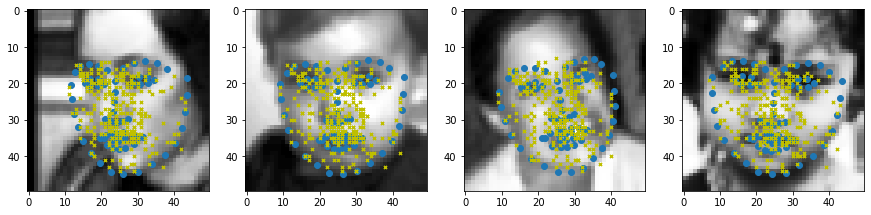

In [112]:
select_features_example = true_features(300, len(mean_pts))
# Plot images with mean shape and 400 extracted points
imgs = (0, 1, 100, 50)
plt.figure(figsize=(15,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.imshow(training_images_preprocessed[index], cmap='gray')
  runtime_features_example = np.reshape([cvt_to_runtime_feature(f, forest.updated_data[index][2]) for f in select_features_example], (-1, 2))
  plt.scatter(forest.updated_data[index][2][:,0], forest.updated_data[index][2][:,1])
  plt.scatter(runtime_features_example[:, 0], runtime_features_example[:, 1], c='y', s=10, marker='x')

# Repeat for stages 1 to 10 - get test results

I create 10 ensembles of regression trees and find the avg sum of error for training and test set.

I also make final predictions for test set.

WARNING THIS TAKES A WHILE TO RUN

In [115]:
save_error_train= []
save_error_test = []
initial_shapes = np.full(pts.shape, mean_pts)
initial_error_train = [sum_of_sq_errors(cs, gt) for (cs, gt) in zip(initial_shapes, train_pts)]
initial_error_test = [sum_of_sq_errors(cs, gt) for (cs, gt) in zip(initial_shapes, train_pts)]
save_error_train.append(np.average(initial_error_train))
save_error_test.append(np.average(initial_error_test))

#initialse variables 
forest_ = forest
apply_model_train, apply_model_test, apply_model_example, apply_model_REAL_TEST_SET = [mean_pts]*len(training_images_preprocessed),[mean_pts]*len(testing_images_preprocessed),[mean_pts]*len(example_images_preprocessed),[mean_pts]*len(real_test_set)
for i in range(9):
  apply_model_train = [apply_model_to_unseen(img, forest_, new_shape) for img, new_shape in zip(training_images_preprocessed, apply_model_train)]
  apply_model_test = [apply_model_to_unseen(img, forest_, new_shape) for img, new_shape in zip(testing_images_preprocessed, apply_model_test)]
  apply_model_example = [apply_model_to_unseen(img, forest_, new_shape) for img, new_shape in zip(example_images_preprocessed, apply_model_example)]
  apply_model_REAL_TEST_SET = [apply_model_to_unseen(img, forest_, new_shape) for img, new_shape in zip(real_test_set, apply_model_REAL_TEST_SET)]

  error_train = np.average([sum_of_sq_errors(cs, gt) for (cs, gt) in zip(apply_model_train, train_pts)])
  save_error_train.append(np.average(error_train))
  print("train error: ", error_train)
  error_test = [sum_of_sq_errors(cs, gt) for (cs, gt) in zip(apply_model_test, test_pts)]
  save_error_test.append(np.average(error_test))
  print("test error: ", np.average(error_test))

  forest_ = regression_forest(forest_.updated_data, 500, 400, 6, 0.01)
  forest_.build_forest()
  

train error:  310.5637913804903
test error:  343.88079056602766
0
100
200
300
400
train error:  233.7637755119001
test error:  269.2258196046144
0
100
200
300
400
train error:  205.7938431654223
test error:  243.32808383643527
0
100
200
300
400
train error:  190.98924487322316
test error:  229.60307309415884
0
100
200
300
400
train error:  182.7158703206765
test error:  222.7829076761064
0
100
200
300
400
train error:  177.40856188934524
test error:  218.69476663327916
0
100
200
300
400
train error:  173.50382357712314
test error:  216.1351047871394
0
100
200
300
400
train error:  170.1950860734839
test error:  213.9427843473677
0
100
200
300
400
train error:  167.62876894914842
test error:  211.9367012017101
0
100
200
300
400


resize test points

In [0]:
real_test_pts_resized = [p/scale_factor for p in apply_model_REAL_TEST_SET]
example_pts_resized = [p/scale_factor for p in apply_model_example]


In [0]:
real_test_set = np.load('test_images.npz', allow_pickle=True)
real_test_set = real_test_set['images']

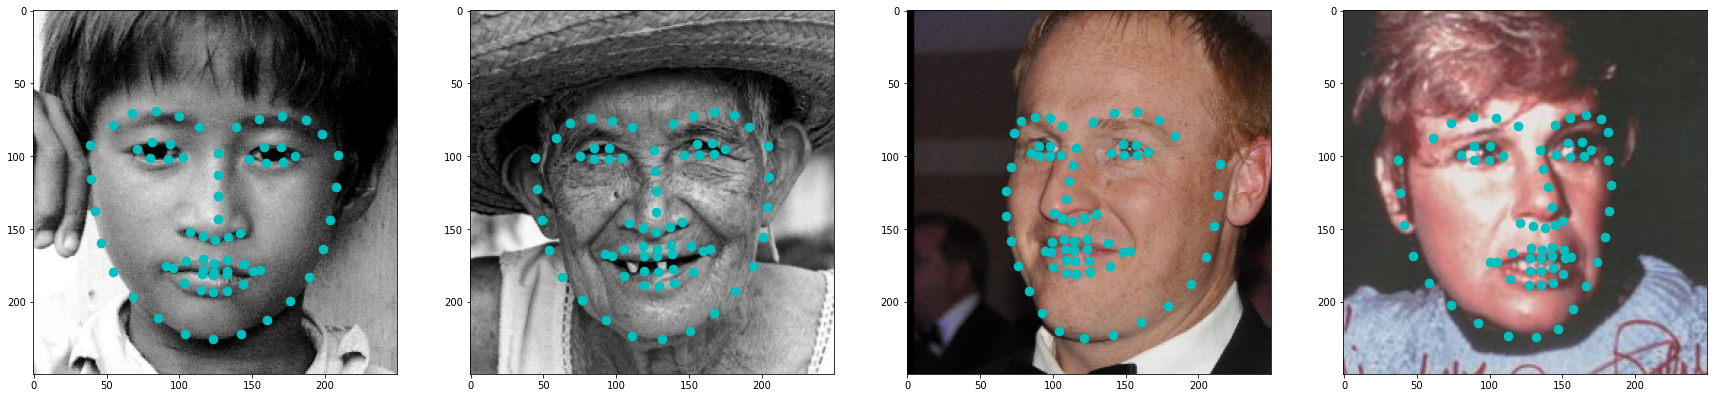

In [138]:
# show on images
imgs = (0,1,100,50)
depth_ = 5
plt.figure(figsize=(30,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.imshow(real_test_set[index], cmap='gray')
  plt.scatter(real_test_pts_resized[index][:,0], real_test_pts_resized[index][:,1], c = 'c', s=75)

In [0]:
from google.colab import files

def save_as_csv(points, location = '.'):
  """
  Save the points out as a .csv file
  :param points: numpy array of shape (no_image, no_points, 2) to be saved
  :param location: Directory to save results.csv in. Default to current working directory
  """
  np.savetxt(fname='results.csv', X=np.reshape(points, (points.shape[0], -1)), delimiter=',')
  files.download("results.csv")

save_as_csv(np.array(real_test_pts_resized))

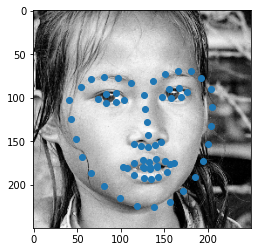

In [158]:
check = np.loadtxt(
    fname='results.csv', delimiter=","
)
check = np.array(check)
check_results = [pt.reshape(mean_pts.shape) for pt in check]
plt.imshow(real_test_set[89])
plt.scatter(check_results[89][:,0],check_results[89][:,1])

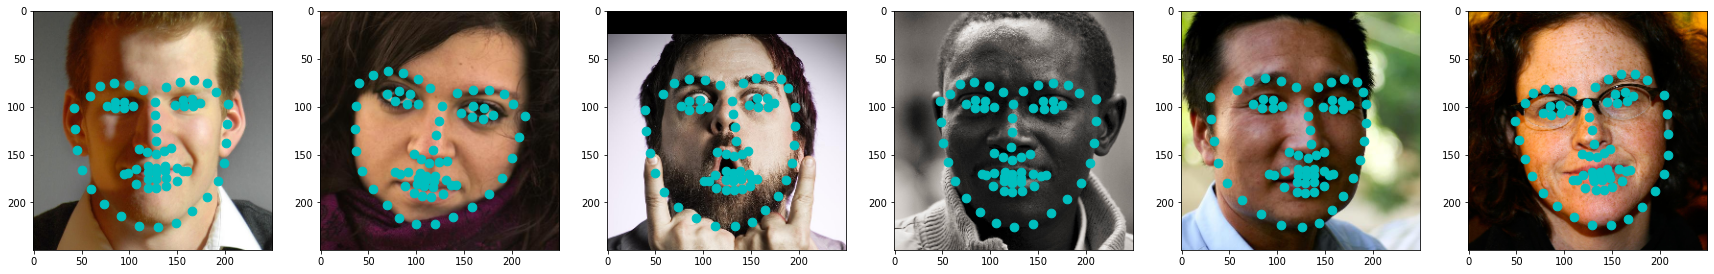

In [159]:
# show on images
imgs = (0,1,2,3,4,5)
depth_ = 5
plt.figure(figsize=(30,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.imshow(example_images[index])
  plt.scatter(example_pts_resized[index][:,0], example_pts_resized[index][:,1], c = 'c', s=75)

# Model performance

211.9367012017101


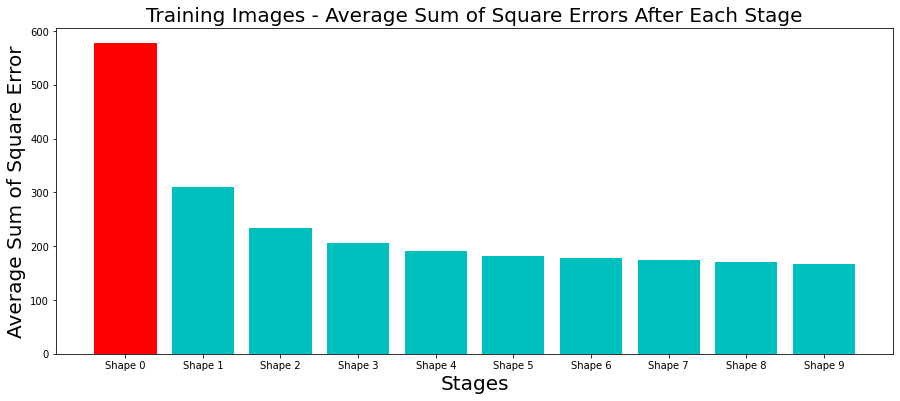

In [160]:
# save_error_train[0] = np.average(save_error_train[0]) 
plt.figure(figsize=(15,6))
a = plt.bar(x=range(len(save_error_train)), height=save_error_train, color=('c','c','c','c','c','c','c','c','c','c'))
plt.title('Training Images - Average Sum of Square Errors After Each Stage', size=20)
plt.xlabel('Stages', size=20)
plt.ylabel('Average Sum of Square Error', size=20)
a[0].set_color('r')
plt.xticks(range(len(save_error_train)), ['Shape 0', 'Shape 1','Shape 2','Shape 3','Shape 4','Shape 5','Shape 6','Shape 7', 'Shape 8','Shape 9'])
print(save_error_test[9])

211.9367012017101


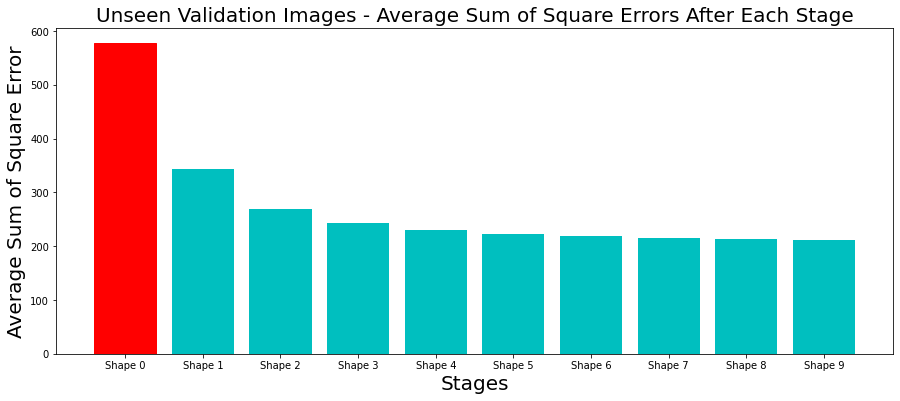

In [161]:
# save_error_test[0] = np.average(save_error_test[0]) 
plt.figure(figsize=(15,6))
a = plt.bar(x=range(len(save_error_test)), height=save_error_test, color=('c','c','c','c','c','c','c','c','c','c'))
plt.title('Unseen Validation Images - Average Sum of Square Errors After Each Stage', size=20)
plt.xlabel('Stages', size=20)
plt.ylabel('Average Sum of Square Error', size=20)
a[0].set_color('r')
plt.xticks(range(len(save_error_train)), ['Shape 0', 'Shape 1','Shape 2','Shape 3','Shape 4','Shape 5','Shape 6','Shape 7', 'Shape 8','Shape 9'])
print(save_error_test[9])

In [0]:
# index = 0
# plt.figure(figsize=(25,15))
# plt.subplot(1,4,1)
# plt.imshow(training_images_grayscale[index], cmap='gray')
# plt.title('Shape 0')
# plt.scatter(mean_pts[:,0]/scale_factor, mean_pts[:,1]/scale_factor, c='r', s =75)

# plt.subplot(1,4,2)
# plt.title('Shape 1')
# plt.imshow(training_images_grayscale[index], cmap='gray')
# new_shape = apply_model_to_unseen(training_images_preprocessed[index], forest, mean_pts)
# plt.scatter(new_shape[:,0]/scale_factor, new_shape[:,1]/scale_factor, c = 'c', s=75)
# plt.subplot(1,4,3)
# plt.title('Shape 2')
# plt.imshow(training_images_grayscale[index], cmap='gray')
# new_shape2 = apply_model_to_unseen(training_images_preprocessed[index], forest_stage_2, new_shape)
# plt.scatter(new_shape2[:,0]/scale_factor, new_shape2[:,1]/scale_factor, c = 'c', s=75)
# plt.subplot(1,4,4)
# plt.title('Shape 3')
# plt.imshow(training_images_grayscale[index], cmap='gray')
# new_shape3 = apply_model_to_unseen(training_images_preprocessed[index], forest_stage_3, new_shape2)
# plt.scatter(new_shape3[:,0]/scale_factor, new_shape3[:,1]/scale_factor, c = 'c', s=75)


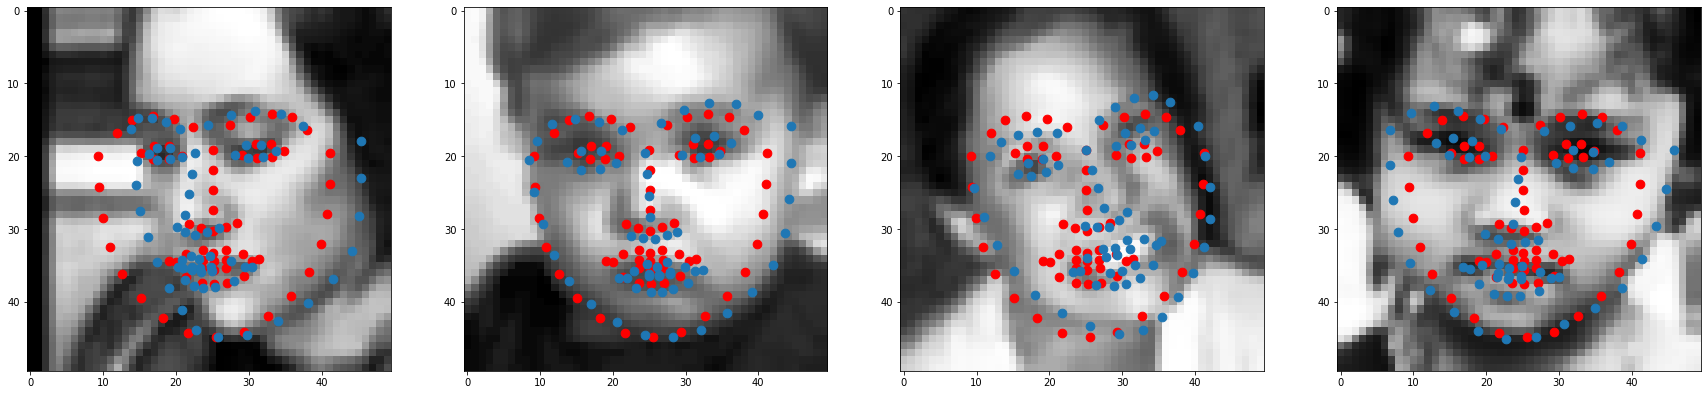

In [166]:
# show on images
imgs = (0,1,100,50)
depth_ = 5
plt.figure(figsize=(30,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.imshow(training_images_preprocessed[index], cmap='gray')
  plt.scatter(mean_pts[:,0], mean_pts[:,1], s=75, c='r')
  plt.scatter(apply_model_train[index][:,0], apply_model_train[index][:,1], s =75)



# Extension tasks - face segmentation

In [0]:
class segment_image:

  def __init__(self, img, model_pts):
    self.img = img
    self.pts = model_pts
    self.forehead = self.isolate_forehead()
    self.segmented_forehead = self.segment_forehead_K_means()
    
    self.contour_forehead = self.contour_forehead()
    self.segment_face()

  def isolate_forehead(self):
    # forehead
    img_forehead = self.img[0:max(int(self.pts[0][1]),int(self.pts[16][1])), int(self.pts[0][0]):int(self.pts[16][0])]
    return img_forehead

  def segment_forehead_K_means(self):
    from cv2 import kmeans
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values_train = self.forehead.reshape((-1, 3))
    pixel_values_train = np.float32(pixel_values_train)

    # define stopping criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 2
    _, labels, (centers) = cv2.kmeans(pixel_values_train, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    labels = labels.flatten()
    segmented_image = centers[labels.flatten()]
    # reshape back to the original image dimension

    return segmented_image.reshape(self.forehead.shape)

  def contour_forehead(self):
    # apply closing to get rid of sparse pixels and retain main shapes
    kernel = np.ones((5,5),np.uint8)
    opened = cv2.morphologyEx(self.segmented_forehead,cv2.MORPH_OPEN, kernel, iterations=3)
    
    imgray = cv2.cvtColor(opened,cv2.COLOR_BGR2GRAY)
    imgray = cv2.copyMakeBorder(imgray, 10, 10, 10, 10, cv2.BORDER_CONSTANT) 
    
    ret,thresh = cv2.threshold(imgray,100,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    # find the biggest countour (c) by the area
    c = max(contours, key = cv2.contourArea)
    min_cont = min([cont[0][1] for cont in c])
    max_cont = max([cont[0][1] for cont in c])     
    c = [cont for cont in c if cont[0][1] < min_cont + (max_cont - min_cont)*0.4]
    cv2.drawContours(imgray,c,-1,(0,0,0),3)
    plt.imshow(imgray)
    return np.array(c)

  def segment_face(self):
    self.contour_forehead = self.contour_forehead + [self.pts[0][0],0]
    pts = np.concatenate([self.contour_forehead.reshape(len(self.contour_forehead), 2), self.pts[:17].astype(np.int32)])
    coords = pts
    center = tuple(map(operator.truediv, reduce(lambda x, y: map(operator.add, x, y), coords), [len(coords)] * 2))
    sort_pts = sorted(coords, key=lambda coord: (-135 - math.degrees(math.atan2(*tuple(map(operator.sub, coord, center))[::-1]))) % 360)
    sort_pts = np.array(sort_pts).reshape(len(sort_pts), 2)
    plt.scatter(sort_pts[:,0], sort_pts[:,1])
    sort_pts = sort_pts.astype(np.int32)
    # mask = np.zeros(self.img.shape, self.img.dtype)
    cv2.fillPoly(self.img, [sort_pts], (0,0,0))
    # self.img = cv2.bitwise_and(self.img, mask)

In [0]:
#resize pts
train_pts_resized = [p/scale_factor for p in apply_model_train]
test_pts_resized = [p/scale_factor for p in apply_model_test]

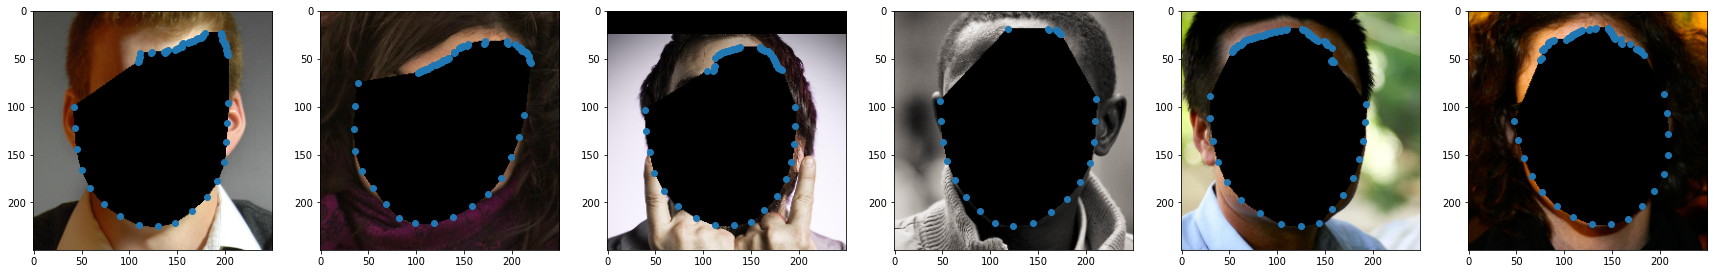

In [169]:
# show on images
imgs = (0,1,2,3,4,5)
depth_ = 5
plt.figure(figsize=(30,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  img= segment_image(example_images[index].copy(), example_pts_resized[index]).img
  plt.imshow(img)


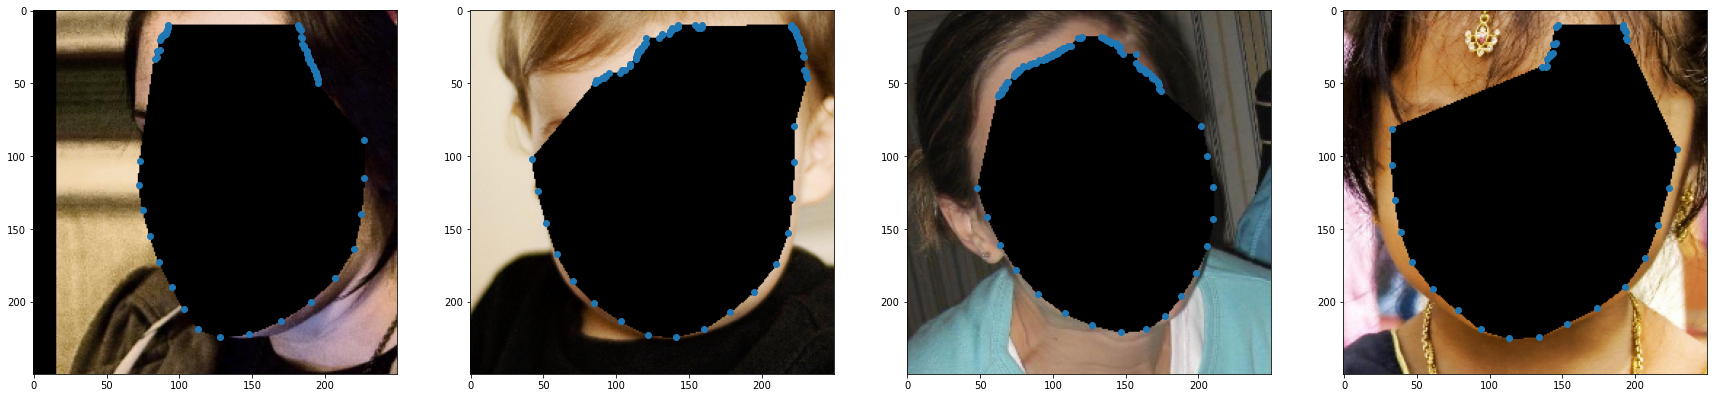

In [170]:
# show on images
imgs = (0,1,100,50)
depth_ = 5
plt.figure(figsize=(30,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  img= segment_image(images[index].copy(), train_pts_resized[index]).img
  plt.imshow(img)


# Extension tasks - Apply graphical effect to face

In [0]:
class graphical_effect:

  def __init__(self, image, points):
    self.img = image
    self.points = points
    self.factor = 1.8

    left_y,right_y,mouth_y = [37,38,40,41],[43,44,46,47],[50,52,56,58]
    left_x,right_x,mouth_x = [36, 39], [42, 45], [48, 54]

    self.left_eye = self.extract_face_part(left_x, left_y)
    self.right_eye = self.extract_face_part(right_x, right_y)
    self.mouth = self.extract_face_part(mouth_x, mouth_y)

    for part in [self.left_eye, self.right_eye,self.mouth]:
      self.img[part[2][0]-10:part[2][0]+int(part[0].shape[0])-10,
              part[1][0]-25:part[1][0]+int(part[0].shape[1])-25] = part[0]

  def extract_face_part(self, pts_x, pts_y):
    pts_y = ( int(min(self.points[pts_y[0]][1], self.points[pts_y[1]][1]) -5), int(max(self.points[pts_y[2]][1], self.points[pts_y[3]][1]) + 5) )
    pts_x = ( int(self.points[pts_x[0]][0]) - 5, int(self.points[pts_x[1]][0]) + 5)
    part=self.img[pts_y[0]:pts_y[1], pts_x[0]:pts_x[1]]
    part=resize_img(part, (math.ceil(part.shape[1]*self.factor / 2.) * 2, math.ceil(part.shape[0]*self.factor / 2.) * 2))
    return   image_histogram_equalization(part), pts_x, pts_y

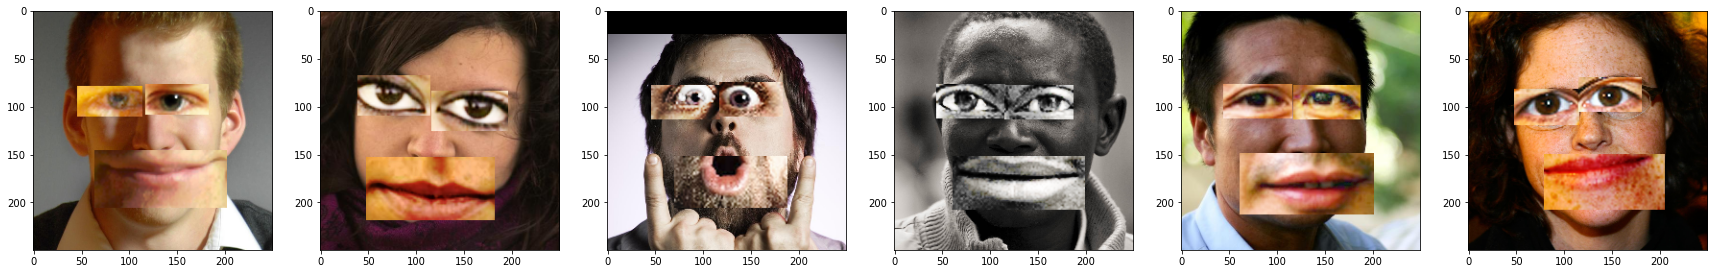

In [172]:
# show on images
imgs = (0,1,2,3,4,5)
depth_ = 5
plt.figure(figsize=(30,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  img= graphical_effect(example_images[i].copy(), example_pts_resized[i].copy()).img

  plt.imshow(img)


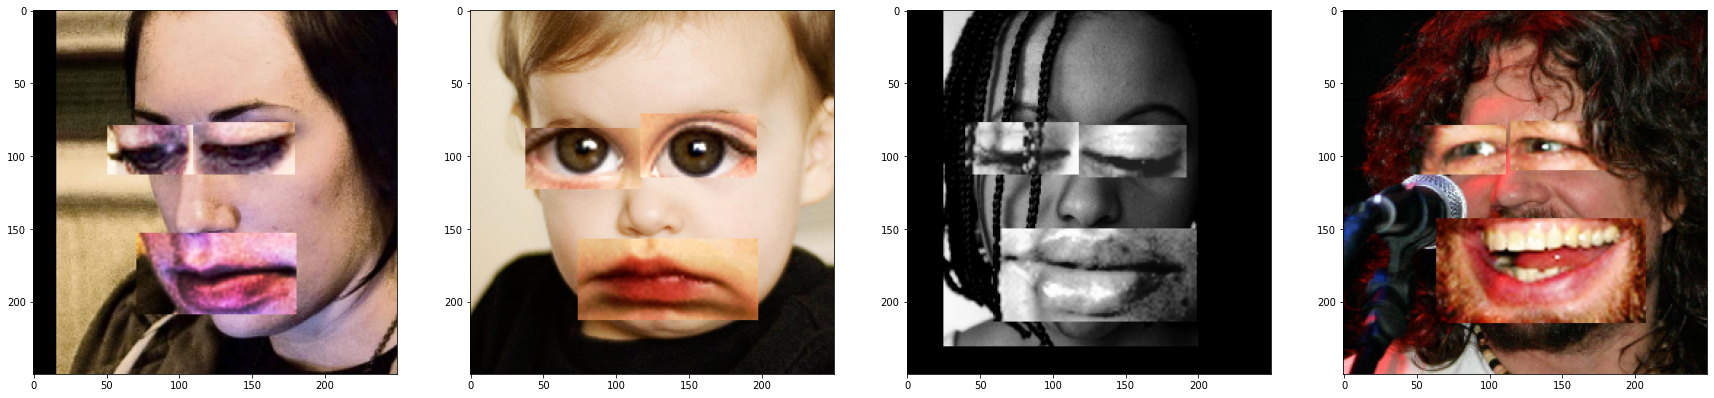

In [173]:
# show on images
imgs = (0,1,100,50)
depth_ = 5
plt.figure(figsize=(30,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  img= graphical_effect(images[i].copy(), train_pts_resized[i].copy()).img

  plt.imshow(img)

# Display example

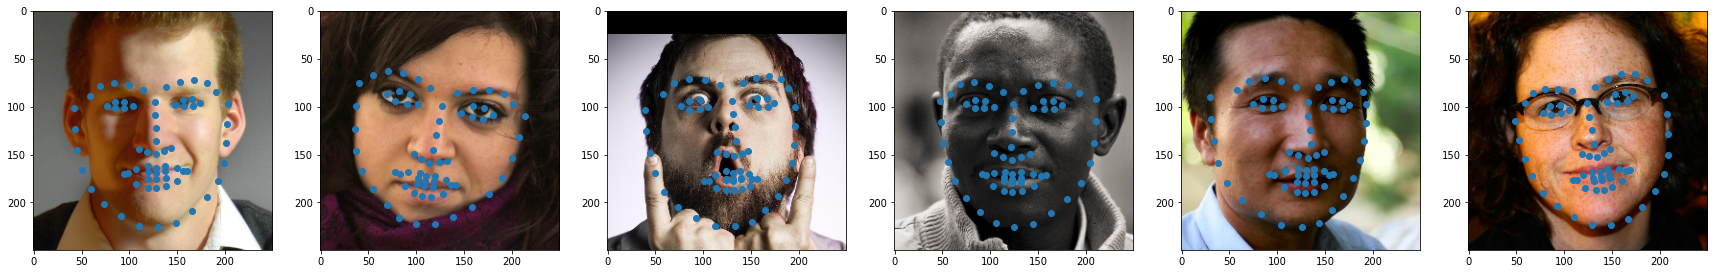

In [174]:
# show on images
imgs = (0,1,2,3,4,5)
depth_ = 5
plt.figure(figsize=(30,15))
for i, index in enumerate(imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.imshow(example_images[i])
  plt.scatter(example_pts_resized[i][:,0], example_pts_resized[i][:,1])